In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from ConvNet import Tomography_nCNN
from DataLoader import Dataset
from SSIM import SSIM
from torch.optim.lr_scheduler import MultiplicativeLR
import time
import copy

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.0  Device: cuda


In [5]:
N=40000

train_id = np.arange(0,32000)
validation_id = np.arange(32000,36000)
test_id = np.arange(36000,N)

len(train_id), len(validation_id), len(test_id)

(32000, 4000, 4000)

In [6]:
n_gpus = 4
learning_rate = 5.0e-4 * n_gpus

BATCH_SIZE = 20 * n_gpus
EPOCHS = 200

In [7]:
train_dataset = Dataset(train_id, nshot=200, nx=320, ny=50)
val_dataset = Dataset(validation_id, nshot=200, nx=320, ny=50)
test_dataset = Dataset(test_id, nshot=200, nx=320, ny=50)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           num_workers=4 * n_gpus, 
                                           pin_memory=True,
                                           shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                         batch_size = BATCH_SIZE,
                                         num_workers=4 * n_gpus, 
                                         pin_memory=True,
                                         shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          num_workers=4 * n_gpus, 
                                          pin_memory=True,
                                          shuffle = False)

In [9]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([80, 1, 320, 200]) type: torch.FloatTensor
y_train: torch.Size([80, 1, 320, 50]) type: torch.FloatTensor


In [10]:
model = torch.nn.DataParallel(Tomography_nCNN().cuda(), device_ids=[0, 1, 2, 3])
#model = Tomography_CNN().cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, amsgrad=True)
scheduler = MultiplicativeLR(optimizer, lr_lambda = lambda epoch:0.95)

ssim = SSIM()

In [11]:
def train_model(model, optimizer, scheduler, num_epochs=None):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1.0
    train_losses, train_mae_losses, train_mse_losses, train_ssim_losses = [],[],[],[]
    val_losses, val_mae_losses, val_mse_losses, val_ssim_losses = [],[],[],[]

    for epoch in range(num_epochs):
        since = time.time()
        print('\nEpoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 각 Epoch은 학습 단계와 검증 단계를 거침
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 학습 모드 설정
                train_mae = 0.0
                train_mse = 0.0
                train_ssim = 0.0
                train_loss = 0.0
                
                for image, label in train_loader:
                    image, label = image.cuda(), label.cuda()
                    optimizer.zero_grad()
                    output = model(image)
                    mae_loss = F.l1_loss(output, label)
                    mse_loss = F.mse_loss(output, label)
                    ssim_loss = ssim(output, label)
                    loss = mae_loss + mse_loss + (1 - ssim_loss)
                    
                    train_mae += mae_loss.detach()
                    train_mse += mse_loss.detach()
                    train_ssim += ssim_loss.detach()
                    train_loss += loss.detach()
                    
                    loss.backward()
                    optimizer.step()
                
                scheduler.step()
                epoch_train_mae = train_mae / len(train_loader.dataset) * BATCH_SIZE
                epoch_train_mse = train_mse / len(train_loader.dataset) * BATCH_SIZE
                epoch_train_ssim = train_ssim / len(train_loader.dataset) * BATCH_SIZE
                epoch_train_loss = train_loss / len(train_loader.dataset) * BATCH_SIZE
                train_mae_losses.append(epoch_train_mae.cpu())
                train_mse_losses.append(epoch_train_mse.cpu())
                train_ssim_losses.append(epoch_train_ssim.cpu())
                train_losses.append(epoch_train_loss.cpu())
                print('{} Loss: {:.4f} MAE: {:.4f} MSE {:.4f} SSIM {:.4f}'.format(
                    phase, epoch_train_loss, epoch_train_mae, epoch_train_mse, epoch_train_ssim))
                
                time_elapsed = time.time() - since
                
            else:
                model.eval()  # 검증 모드 설정
                val_mae = 0.0
                val_mse = 0.0
                val_ssim = 0.0
                val_loss = 0.0
                
                for image, label in val_loader:
                    image, label = image.cuda(), label.cuda()
                    output = model(image)
                    mae_loss = F.l1_loss(output, label)
                    mse_loss = F.mse_loss(output, label)
                    ssim_loss = ssim(output, label)
                    loss = mae_loss + mse_loss + (1 - ssim_loss)
                    
                    val_mae += mae_loss.detach()
                    val_mse += mse_loss.detach()
                    val_ssim += ssim_loss.detach()
                    val_loss += loss.detach()
                    
                epoch_val_mae = val_mae / len(val_loader.dataset) * BATCH_SIZE
                epoch_val_mse = val_mse / len(val_loader.dataset) * BATCH_SIZE
                epoch_val_ssim = val_ssim / len(val_loader.dataset) * BATCH_SIZE
                epoch_val_loss = val_loss / len(val_loader.dataset) * BATCH_SIZE
                val_mae_losses.append(epoch_val_mae.cpu())
                val_mse_losses.append(epoch_val_mse.cpu())
                val_ssim_losses.append(epoch_val_ssim.cpu())
                val_losses.append(epoch_val_loss.cpu())
                print('{} Loss: {:.4f} MAE: {:.4f} MSE {:.4f} SSIM {:.4f}'.format(
                    phase, epoch_val_loss, epoch_val_mae, epoch_val_mse, epoch_val_ssim))
                print('Training time elapesd per epoch {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
            
            # 모델 복사(Deep Copy)
            if phase == 'valid' and epoch_val_loss < best_loss:
                best_loss = epoch_val_loss
                best_model_wts = copy.deepcopy(model.state_dict())


    # 최적의 모델 가중치 로딩
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_mae_losses, train_mse_losses, train_ssim_losses, val_losses, val_mae_losses, val_mse_losses, val_ssim_losses

In [12]:
model_ft, train_losses, train_mae_losses, train_mse_losses, train_ssim_losses, val_losses, val_mae_losses, val_mse_losses, val_ssim_losses = train_model(
    model, optimizer, scheduler, num_epochs=EPOCHS)


Epoch 1/200
----------
train Loss: 0.7434 MAE: 0.2279 MSE 0.1681 SSIM 0.6527
valid Loss: 0.7795 MAE: 0.2691 MSE 0.1638 SSIM 0.6534
Training time elapesd per epoch 5m 7s

Epoch 2/200
----------
train Loss: 0.5553 MAE: 0.1579 MSE 0.0896 SSIM 0.6921
valid Loss: 0.6134 MAE: 0.1973 MSE 0.1044 SSIM 0.6882
Training time elapesd per epoch 4m 58s

Epoch 3/200
----------
train Loss: 0.4981 MAE: 0.1374 MSE 0.0716 SSIM 0.7109
valid Loss: 0.5324 MAE: 0.1530 MSE 0.0881 SSIM 0.7087
Training time elapesd per epoch 4m 59s

Epoch 4/200
----------
train Loss: 0.4657 MAE: 0.1263 MSE 0.0626 SSIM 0.7232
valid Loss: 0.6173 MAE: 0.1785 MSE 0.1289 SSIM 0.6901
Training time elapesd per epoch 4m 58s

Epoch 5/200
----------
train Loss: 0.4431 MAE: 0.1192 MSE 0.0567 SSIM 0.7328
valid Loss: 0.4592 MAE: 0.1240 MSE 0.0607 SSIM 0.7254
Training time elapesd per epoch 4m 58s

Epoch 6/200
----------
train Loss: 0.4245 MAE: 0.1132 MSE 0.0522 SSIM 0.7409
valid Loss: 0.4156 MAE: 0.1110 MSE 0.0490 SSIM 0.7444
Training time 

train Loss: 0.2535 MAE: 0.0633 MSE 0.0174 SSIM 0.8272
valid Loss: 0.3148 MAE: 0.0832 MSE 0.0331 SSIM 0.8015
Training time elapesd per epoch 4m 58s

Epoch 50/200
----------
train Loss: 0.2522 MAE: 0.0630 MSE 0.0171 SSIM 0.8280
valid Loss: 0.3482 MAE: 0.0905 MSE 0.0363 SSIM 0.7787
Training time elapesd per epoch 4m 58s

Epoch 51/200
----------
train Loss: 0.2513 MAE: 0.0628 MSE 0.0170 SSIM 0.8284
valid Loss: 0.2878 MAE: 0.0713 MSE 0.0258 SSIM 0.8093
Training time elapesd per epoch 4m 58s

Epoch 52/200
----------
train Loss: 0.2496 MAE: 0.0623 MSE 0.0167 SSIM 0.8294
valid Loss: 0.3117 MAE: 0.0801 MSE 0.0291 SSIM 0.7976
Training time elapesd per epoch 4m 58s

Epoch 53/200
----------
train Loss: 0.2489 MAE: 0.0621 MSE 0.0166 SSIM 0.8298
valid Loss: 0.3073 MAE: 0.0753 MSE 0.0281 SSIM 0.7961
Training time elapesd per epoch 4m 58s

Epoch 54/200
----------
train Loss: 0.2481 MAE: 0.0619 MSE 0.0164 SSIM 0.8302
valid Loss: 0.2877 MAE: 0.0699 MSE 0.0264 SSIM 0.8087
Training time elapesd per epoch 

train Loss: 0.2291 MAE: 0.0570 MSE 0.0134 SSIM 0.8413
valid Loss: 0.2753 MAE: 0.0671 MSE 0.0250 SSIM 0.8168
Training time elapesd per epoch 4m 58s

Epoch 98/200
----------
train Loss: 0.2289 MAE: 0.0570 MSE 0.0133 SSIM 0.8414
valid Loss: 0.2718 MAE: 0.0657 MSE 0.0246 SSIM 0.8185
Training time elapesd per epoch 4m 58s

Epoch 99/200
----------
train Loss: 0.2287 MAE: 0.0569 MSE 0.0133 SSIM 0.8416
valid Loss: 0.2779 MAE: 0.0686 MSE 0.0254 SSIM 0.8161
Training time elapesd per epoch 4m 58s

Epoch 100/200
----------
train Loss: 0.2285 MAE: 0.0569 MSE 0.0133 SSIM 0.8416
valid Loss: 0.2716 MAE: 0.0658 MSE 0.0245 SSIM 0.8187
Training time elapesd per epoch 4m 59s

Epoch 101/200
----------
train Loss: 0.2283 MAE: 0.0568 MSE 0.0133 SSIM 0.8417
valid Loss: 0.2734 MAE: 0.0666 MSE 0.0246 SSIM 0.8178
Training time elapesd per epoch 4m 59s

Epoch 102/200
----------
train Loss: 0.2283 MAE: 0.0568 MSE 0.0132 SSIM 0.8418
valid Loss: 0.2719 MAE: 0.0659 MSE 0.0246 SSIM 0.8186
Training time elapesd per epo

train Loss: 0.2262 MAE: 0.0563 MSE 0.0129 SSIM 0.8431
valid Loss: 0.2717 MAE: 0.0657 MSE 0.0246 SSIM 0.8186
Training time elapesd per epoch 4m 58s

Epoch 146/200
----------
train Loss: 0.2262 MAE: 0.0563 MSE 0.0130 SSIM 0.8431
valid Loss: 0.2717 MAE: 0.0657 MSE 0.0246 SSIM 0.8186
Training time elapesd per epoch 4m 59s

Epoch 147/200
----------
train Loss: 0.2262 MAE: 0.0563 MSE 0.0130 SSIM 0.8431
valid Loss: 0.2713 MAE: 0.0657 MSE 0.0245 SSIM 0.8189
Training time elapesd per epoch 4m 58s

Epoch 148/200
----------
train Loss: 0.2262 MAE: 0.0563 MSE 0.0130 SSIM 0.8430
valid Loss: 0.2718 MAE: 0.0659 MSE 0.0246 SSIM 0.8187
Training time elapesd per epoch 4m 58s

Epoch 149/200
----------
train Loss: 0.2262 MAE: 0.0563 MSE 0.0130 SSIM 0.8430
valid Loss: 0.2716 MAE: 0.0657 MSE 0.0246 SSIM 0.8188
Training time elapesd per epoch 4m 58s

Epoch 150/200
----------
train Loss: 0.2261 MAE: 0.0563 MSE 0.0129 SSIM 0.8431
valid Loss: 0.2714 MAE: 0.0656 MSE 0.0246 SSIM 0.8188
Training time elapesd per e

train Loss: 0.2259 MAE: 0.0562 MSE 0.0129 SSIM 0.8432
valid Loss: 0.2716 MAE: 0.0658 MSE 0.0246 SSIM 0.8187
Training time elapesd per epoch 4m 58s

Epoch 194/200
----------
train Loss: 0.2260 MAE: 0.0563 MSE 0.0129 SSIM 0.8432
valid Loss: 0.2717 MAE: 0.0657 MSE 0.0246 SSIM 0.8187
Training time elapesd per epoch 4m 58s

Epoch 195/200
----------
train Loss: 0.2260 MAE: 0.0562 MSE 0.0129 SSIM 0.8432
valid Loss: 0.2714 MAE: 0.0656 MSE 0.0246 SSIM 0.8187
Training time elapesd per epoch 4m 59s

Epoch 196/200
----------
train Loss: 0.2259 MAE: 0.0562 MSE 0.0129 SSIM 0.8433
valid Loss: 0.2716 MAE: 0.0656 MSE 0.0246 SSIM 0.8186
Training time elapesd per epoch 4m 58s

Epoch 197/200
----------
train Loss: 0.2260 MAE: 0.0563 MSE 0.0129 SSIM 0.8432
valid Loss: 0.2715 MAE: 0.0658 MSE 0.0245 SSIM 0.8188
Training time elapesd per epoch 4m 58s

Epoch 198/200
----------
train Loss: 0.2259 MAE: 0.0562 MSE 0.0129 SSIM 0.8433
valid Loss: 0.2715 MAE: 0.0657 MSE 0.0245 SSIM 0.8188
Training time elapesd per e

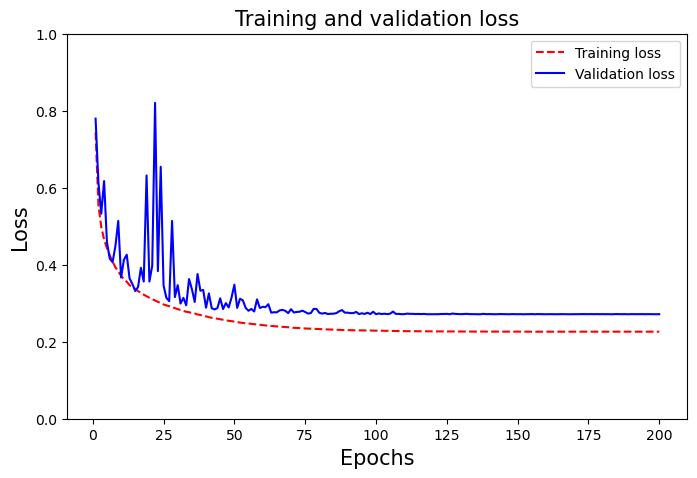

In [13]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(train_losses)+1),train_losses,'r--',label = 'Training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'b-',label = 'Validation loss')
plt.title('Training and validation loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim([0, 1.0])
plt.legend(loc="upper right")

plt.show()

<Figure size 640x480 with 0 Axes>

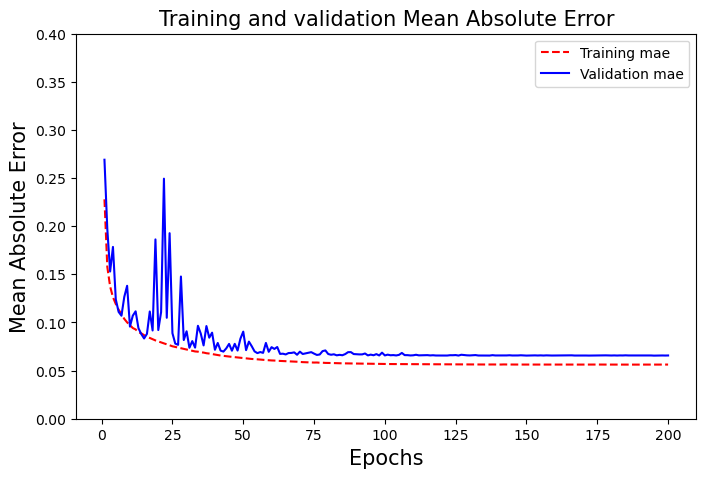

In [14]:
plt.clf()
plt.figure(figsize=[8,5])

plt.plot(range(1,len(train_mae_losses)+1),train_mae_losses,'r--',label = 'Training mae')
plt.plot(range(1,len(val_mae_losses)+1),val_mae_losses,'b-',label = 'Validation mae')
plt.title('Training and validation Mean Absolute Error', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Mean Absolute Error', fontsize=15)
plt.ylim([0, 0.4])
plt.legend(loc="upper right")

plt.show()

<Figure size 640x480 with 0 Axes>

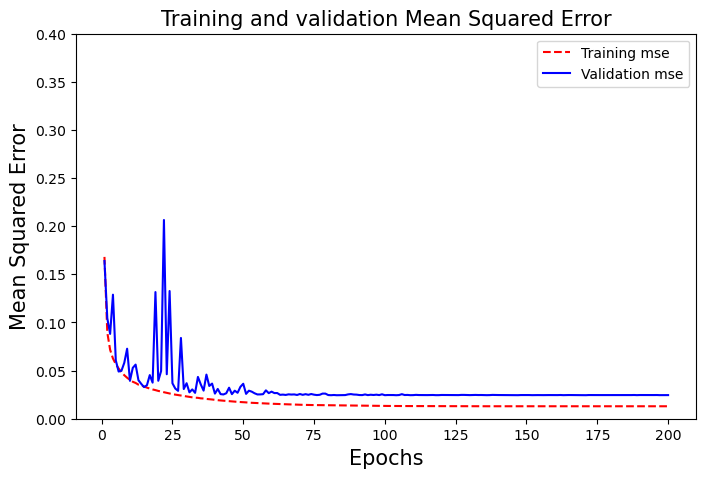

In [15]:
plt.clf()
plt.figure(figsize=[8,5])

plt.plot(range(1,len(train_mse_losses)+1),train_mse_losses,'r--',label = 'Training mse')
plt.plot(range(1,len(val_mse_losses)+1),val_mse_losses,'b-',label = 'Validation mse')
plt.title('Training and validation Mean Squared Error', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.ylim([0, 0.4])
plt.legend(loc="upper right")

plt.show()

<Figure size 640x480 with 0 Axes>

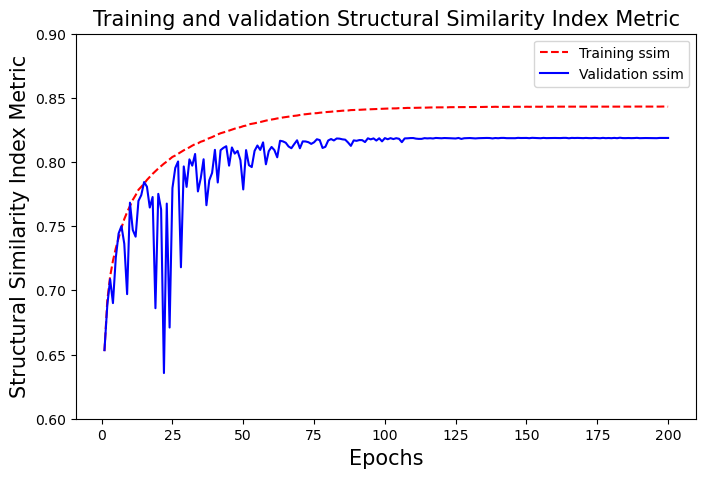

In [16]:
plt.clf()
plt.figure(figsize=[8,5])

plt.plot(range(1,len(train_ssim_losses)+1),train_ssim_losses,'r--',label = 'Training ssim')
plt.plot(range(1,len(val_ssim_losses)+1),val_ssim_losses,'b-',label = 'Validation ssim')
plt.title('Training and validation Structural Similarity Index Metric', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Structural Similarity Index Metric', fontsize=15)
plt.ylim([0.6, 0.9])
plt.legend(loc="upper right")

plt.show()

In [17]:
def evaluate(model, test_loader):
    since = time.time()
    model.eval()
    
    test_mae = 0.0
    test_mse = 0.0
    test_ssim = 0.0
    test_loss = 0.0

    with torch.no_grad():
        for image, label in test_loader:
            image, label = image.cuda(), label.cuda()
            output = model(image)
            mae_loss = F.l1_loss(output, label)
            mse_loss = F.mse_loss(output, label)
            ssim_loss = ssim(output, label)
            loss = mae_loss + mse_loss + (1 - ssim_loss)
            
            test_mae += mae_loss.detach()
            test_mse += mse_loss.detach()
            test_ssim += ssim_loss.detach()
            test_loss += loss.detach()
    
    epoch_test_mae = test_mae / len(test_loader.dataset) * BATCH_SIZE
    epoch_test_mse = test_mse / len(test_loader.dataset) * BATCH_SIZE
    epoch_test_ssim = test_ssim / len(test_loader.dataset) * BATCH_SIZE
    epoch_test_loss = test_loss / len(test_loader.dataset) * BATCH_SIZE
    
    time_elapsed = time.time() - since
    print('Loss: {:.4f} MAE: {:.4f} MSE {:.4f} SSIM {:.4f}'.format(
        epoch_test_loss, epoch_test_mae, epoch_test_mse, epoch_test_ssim))
    print('Total time elapesd of test data {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
    return epoch_test_loss, epoch_test_mae, epoch_test_mse, epoch_test_ssim

In [18]:
PATH = "./weights/Tomography_nCNN.pt"

In [19]:
torch.save(model_ft.state_dict(), PATH)

In [20]:
device = torch.device("cuda")
trained_model = torch.nn.DataParallel(Tomography_nCNN(), device_ids=[0, 1, 2, 3])
#trained_model = Tomography_CNN()
trained_model.load_state_dict(torch.load(PATH))
trained_model.to(device)

DataParallel(
  (module): Tomography_nCNN(
    (layers): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      )
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
      (3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (3): BatchNorm2d(128, eps=1e-05, momentum=0

In [21]:
test_loss, test_mae, test_mse, test_ssim= evaluate(trained_model, test_loader)

Loss: 0.2723 MAE: 0.0662 MSE 0.0247 SSIM 0.8186
Total time elapesd of test data 0m 20s


In [22]:
test_loss, test_mae, test_mse, test_ssim

(tensor(0.2723, device='cuda:0'),
 tensor(0.0662, device='cuda:0'),
 tensor(0.0247, device='cuda:0'),
 tensor(0.8186, device='cuda:0'))

In [23]:
def perc_clip_val(data,perc=100):
    # return clipping value by percent clip, does not apply clipping
    # data: array to clip
    # perc: percent value
    # output: min/max clip values
    mperc=(100.-perc)*0.01*0.5
    tmp=np.sort(data.flatten())
    minloc=int(len(tmp)*mperc)
    maxloc=len(tmp)-minloc-1
    clipmin=tmp[minloc]
    clipmax=tmp[maxloc]
    return clipmin,clipmax

In [24]:
def make_plot(y ,prediction, perc=97):
    #clipmin,clipmax = perc_clip_val(x, perc)
    plt.figure(figsize=[16,3])
    # input seismogram - one shotgather
    #plt.subplot(1,3,1)
    #plt.imshow(np.clip(x,clipmin,clipmax), aspect='auto',cmap='gray_r')
    # true velocity model
    plt.subplot(1,2,1)
    plt.imshow(y.T, vmin=1.5, vmax=5.0)
    plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
    plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
    plt.xlabel("Distance (km)",fontsize=10)
    plt.ylabel("Depth (km)",fontsize=8)
    plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")
    # predicted velocity model
    plt.subplot(1,2,2)
    plt.imshow(prediction.T, vmin=1.5, vmax=5.0)
    plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
    plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
    plt.xlabel("Distance (km)",fontsize=10)
    plt.ylabel("Depth (km)",fontsize=8)
    plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")

In [25]:
def plot_prediction(model, test_loader, ibatch=0):
    model.eval()
    
    with torch.no_grad():
        i = 0
        for image, label in test_loader:
            i += 1
            image, label = image.cuda(), label.cuda()
            output = model(image)
            image, label = image.cpu(), label.cpu()
            output = output.cpu()
            make_plot(label[ibatch].detach().numpy() ,output[ibatch].detach().numpy())
            label[ibatch].detach().numpy().astype(np.float32).tofile("./pred/nCNN/label_test%05d.bin"%(BATCH_SIZE * i))
            output[ibatch].detach().numpy().astype(np.float32).tofile("./pred/nCNN/pred_test%05d.bin"%(BATCH_SIZE * i))

/tmp/ipykernel_98128/3982833261.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[16,3])


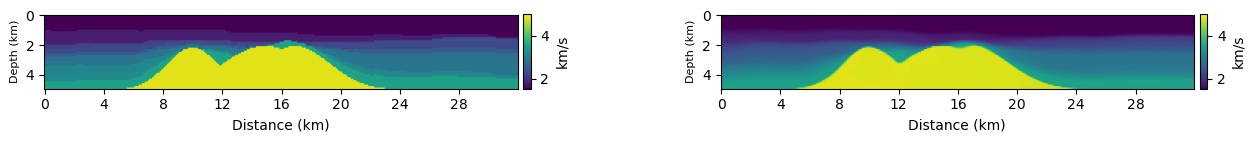

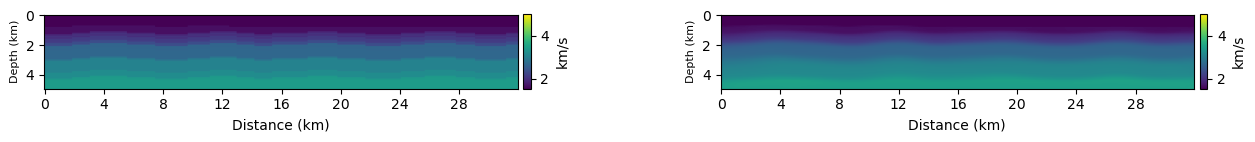

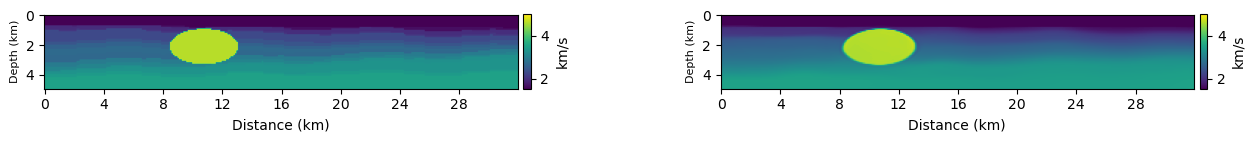

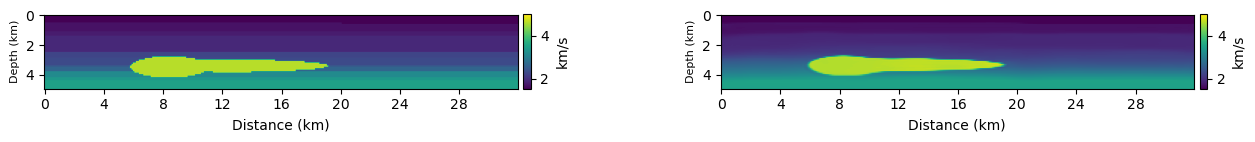

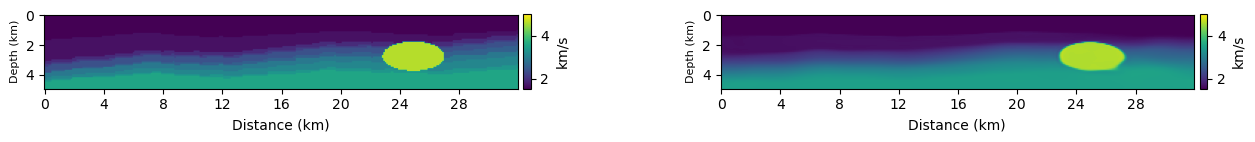

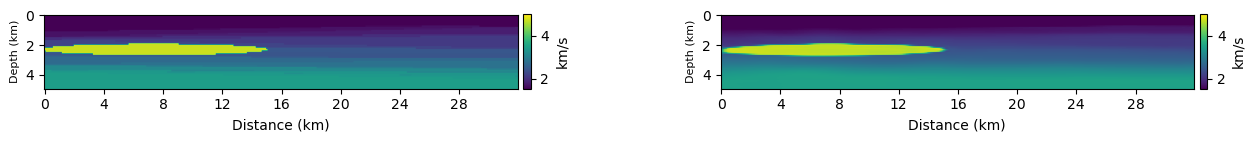

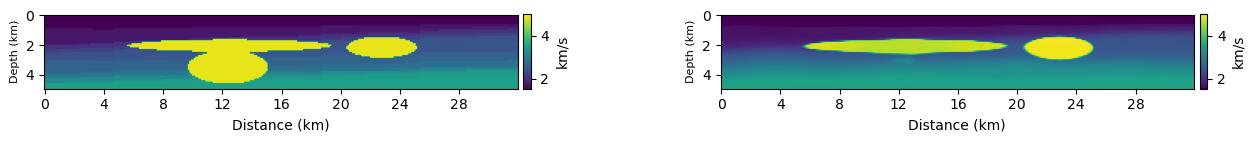

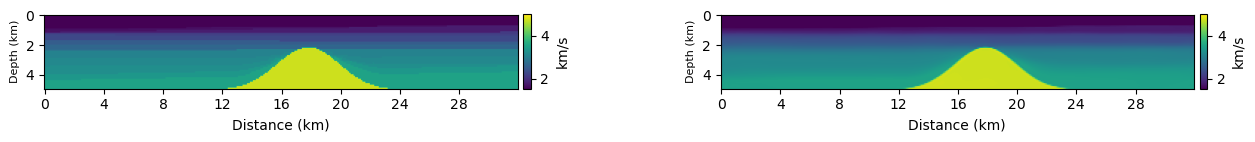

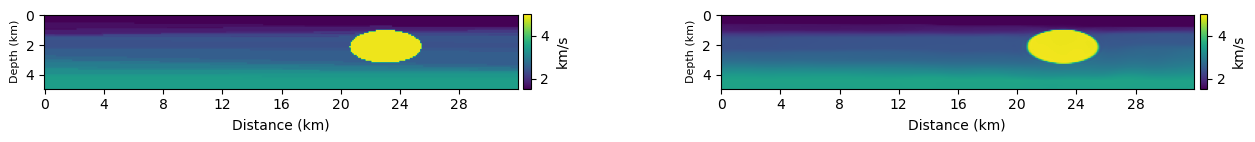

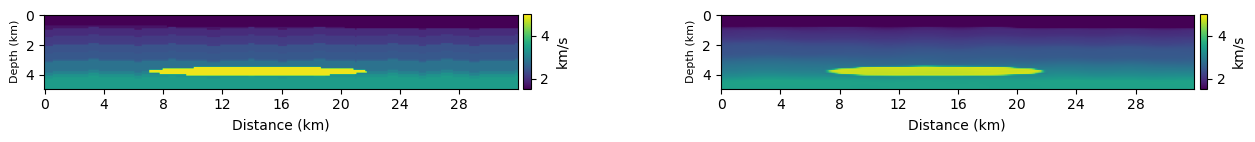

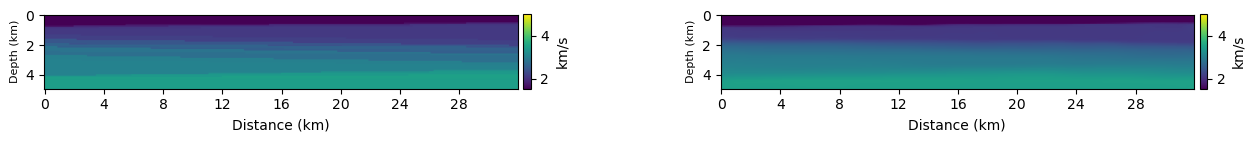

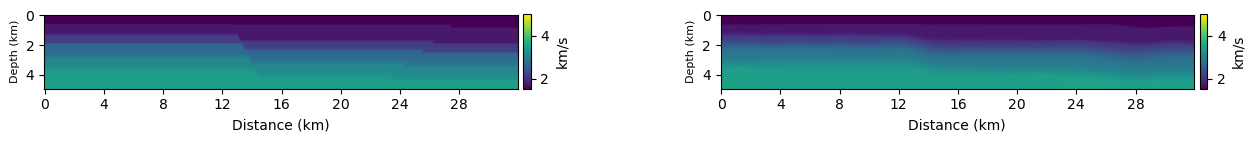

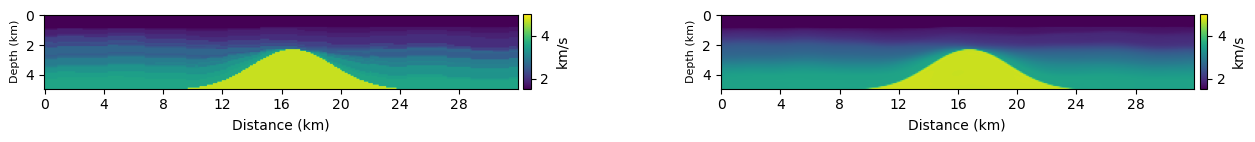

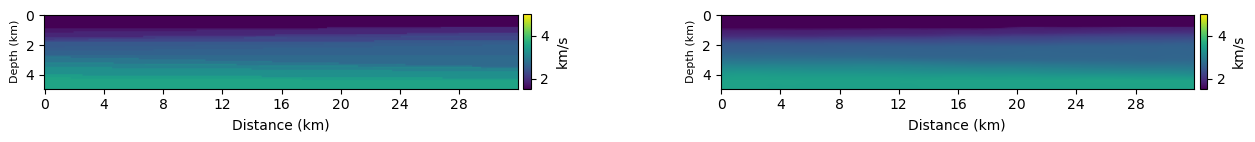

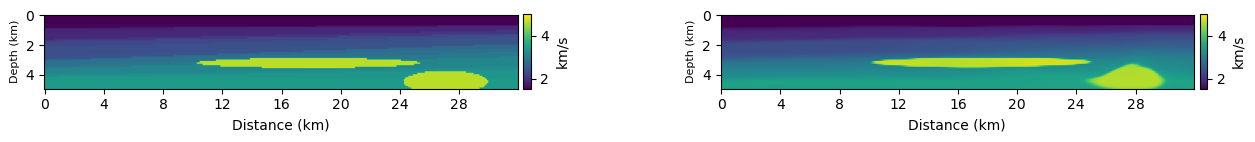

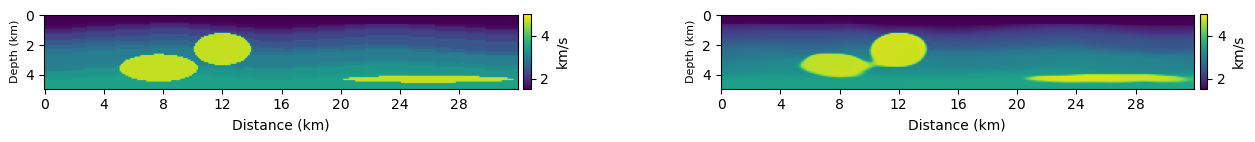

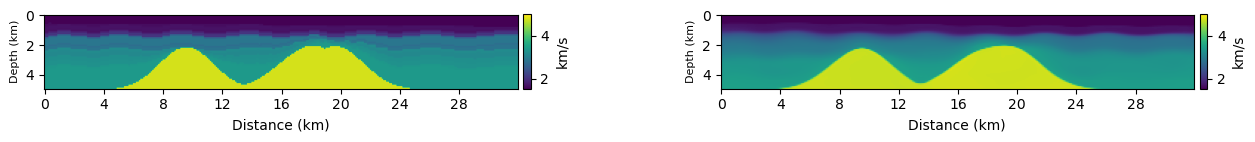

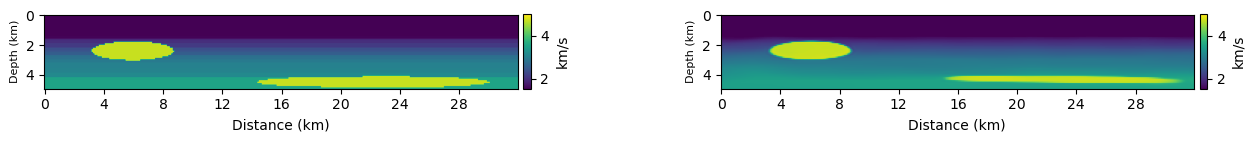

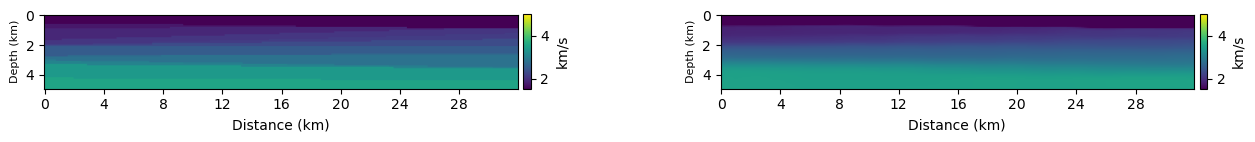

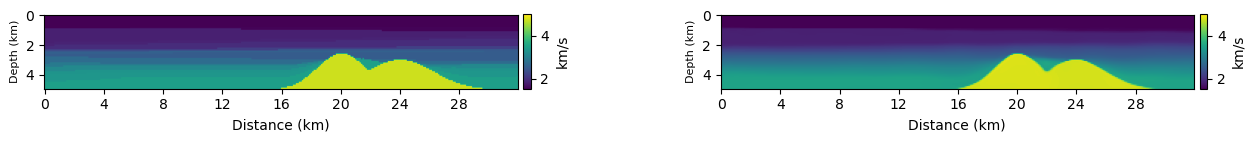

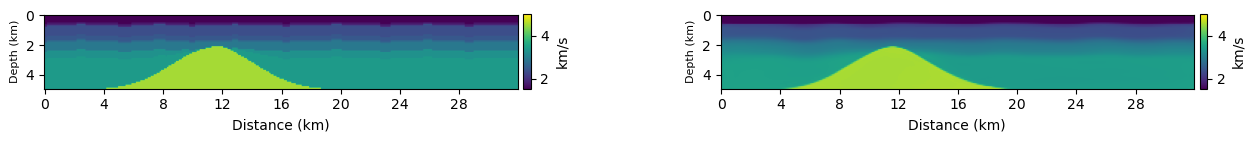

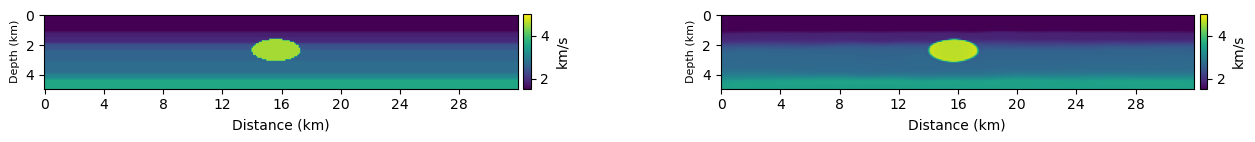

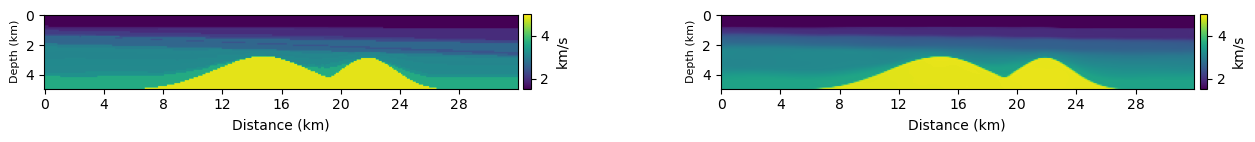

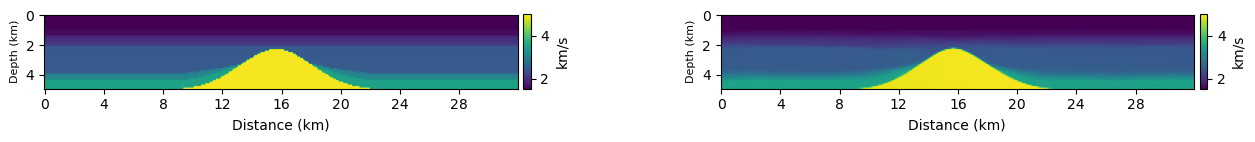

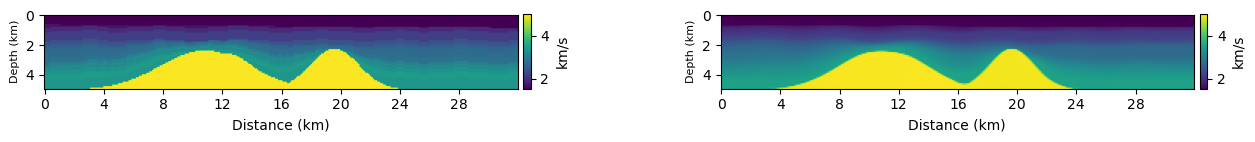

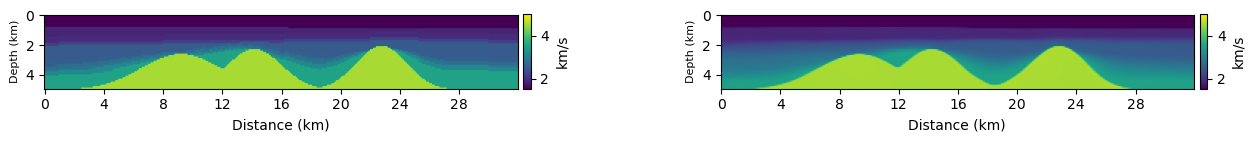

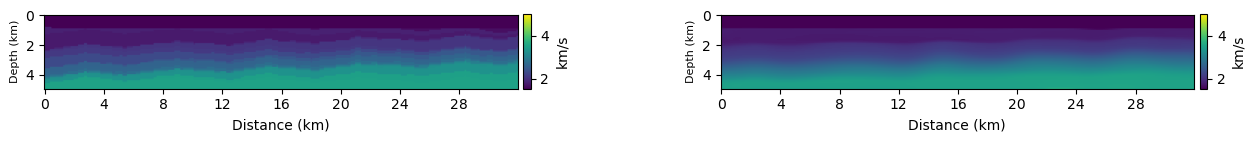

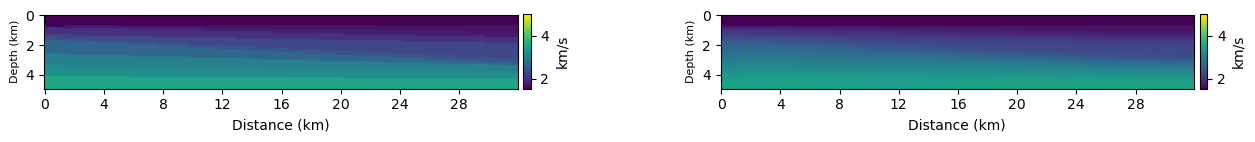

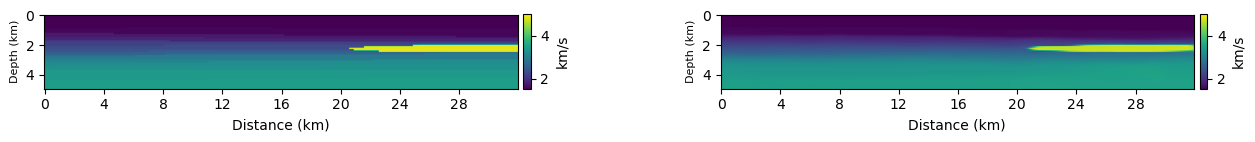

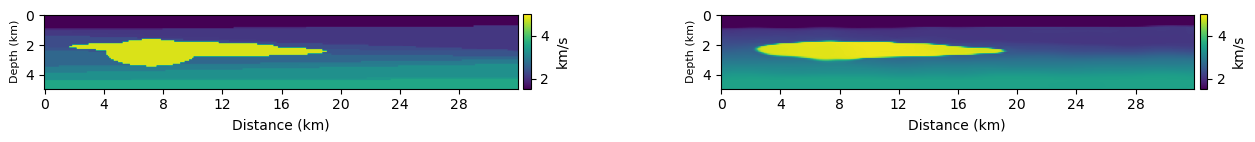

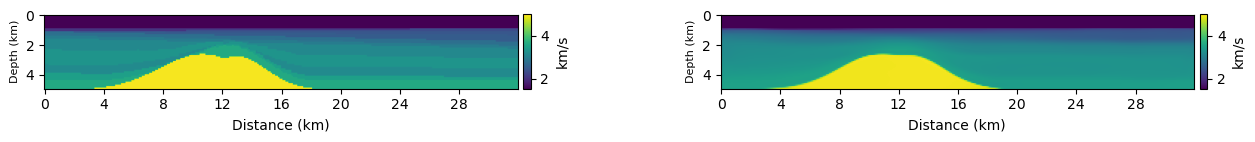

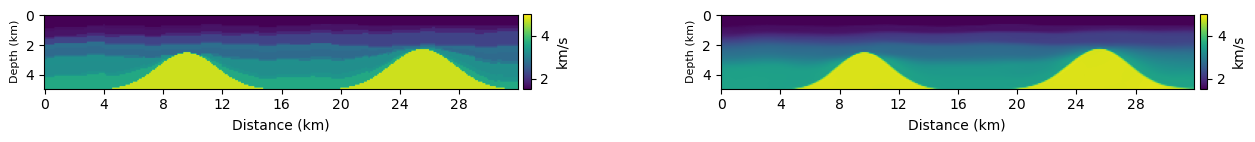

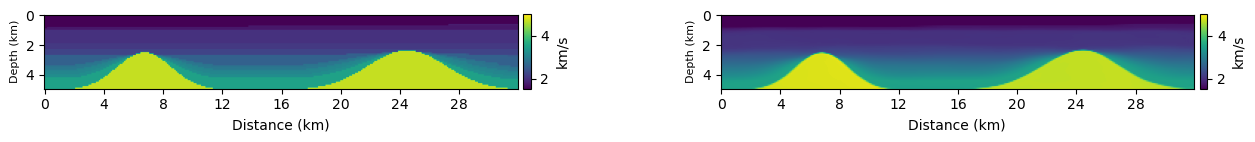

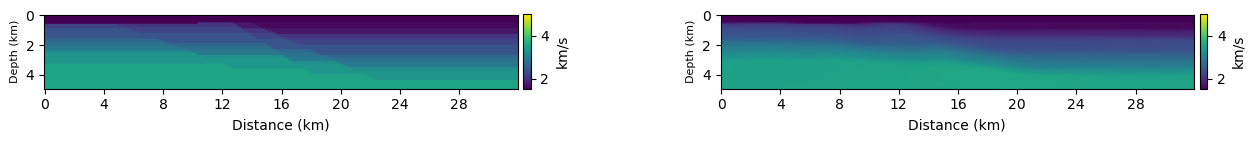

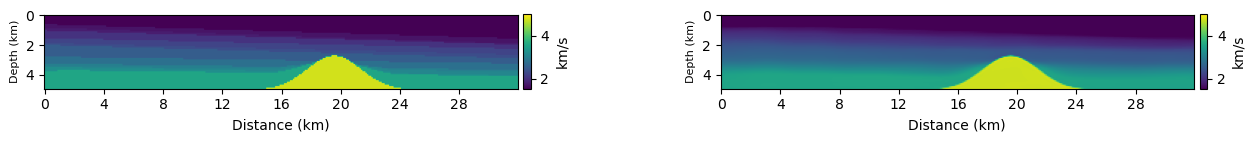

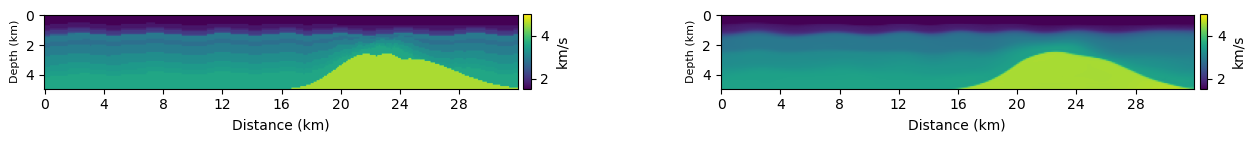

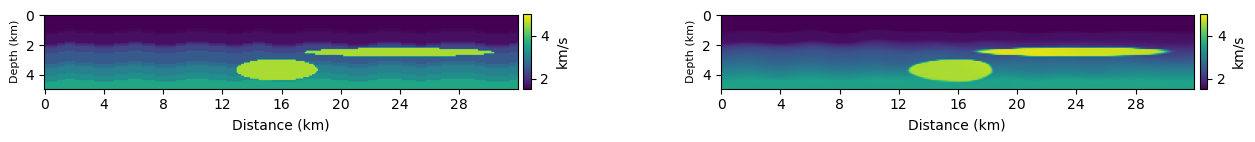

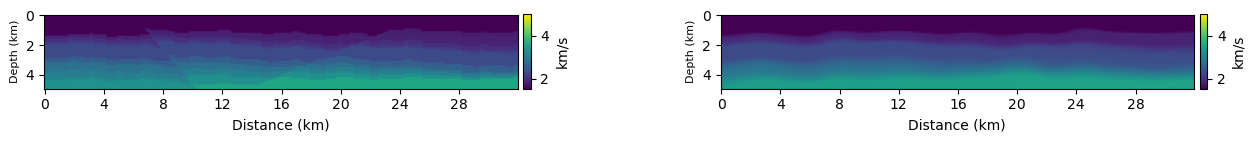

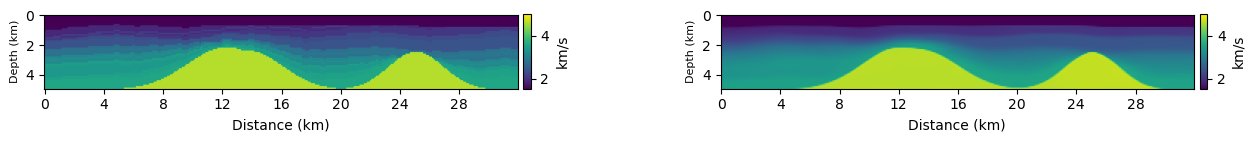

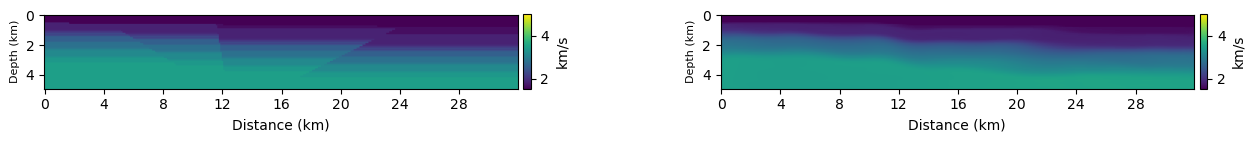

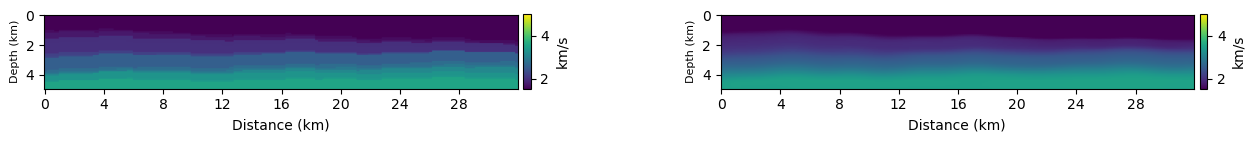

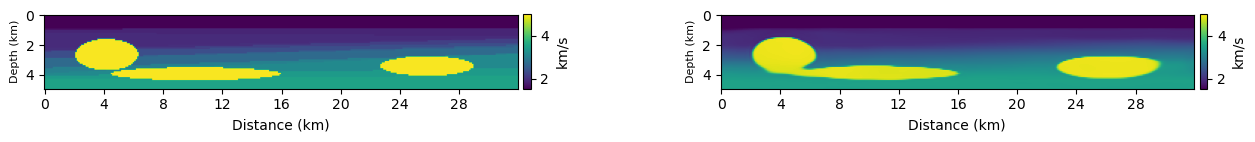

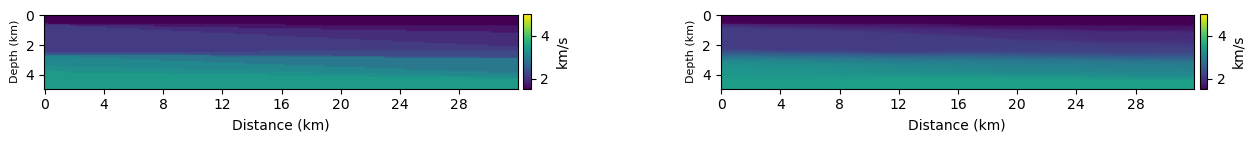

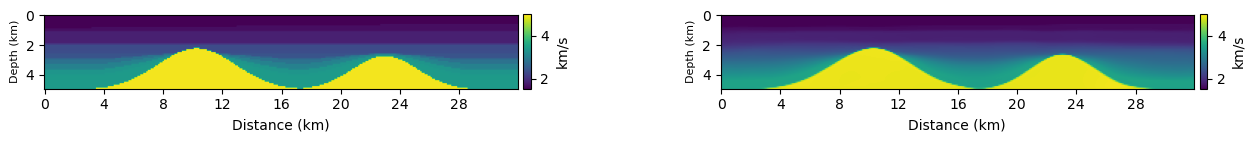

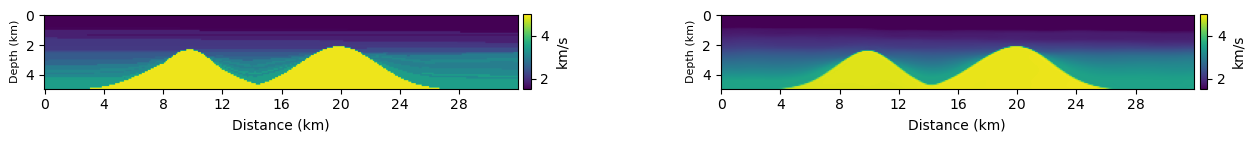

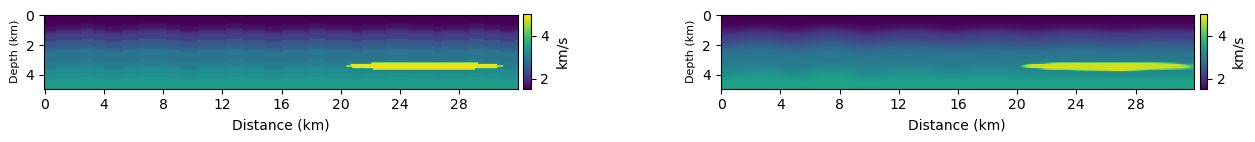

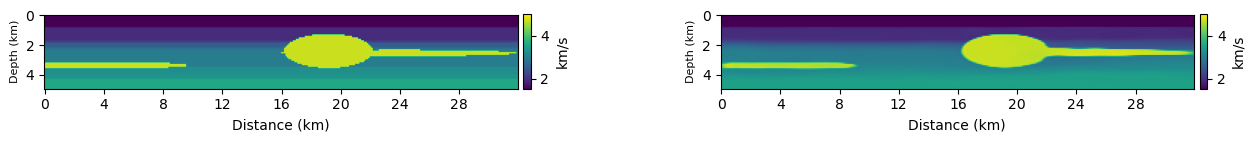

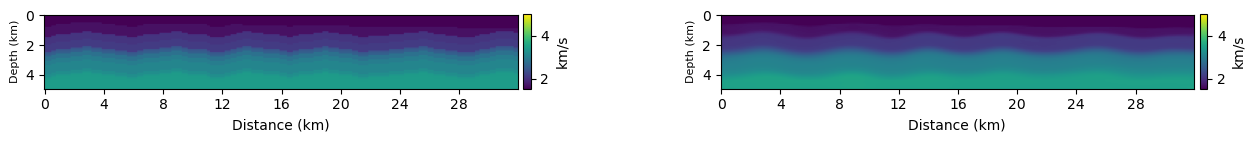

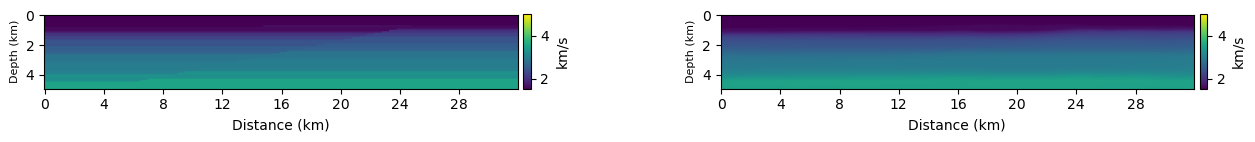

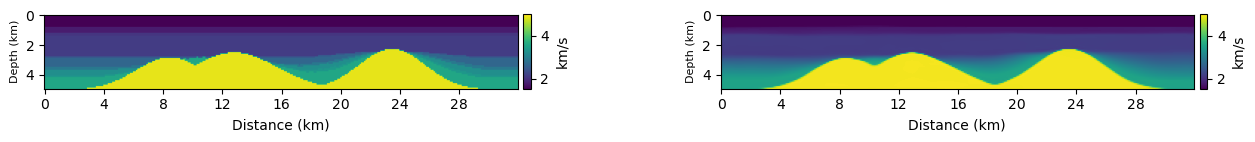

In [26]:
plot_prediction(trained_model, test_loader, ibatch=0)

/tmp/ipykernel_98128/4005291518.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


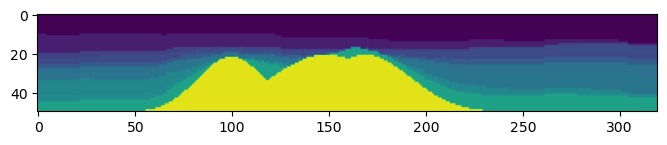

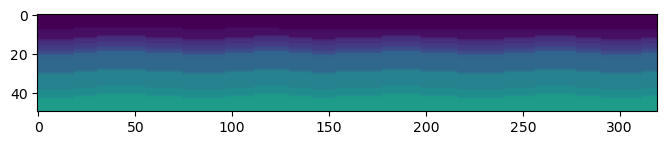

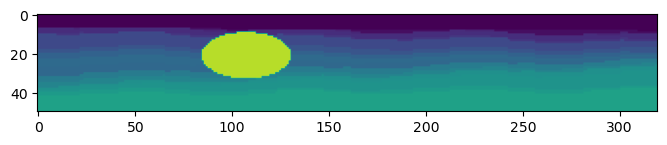

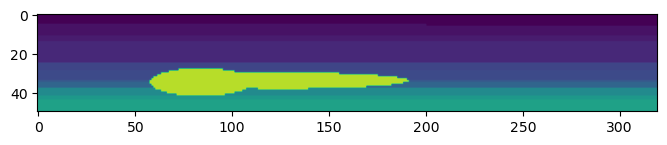

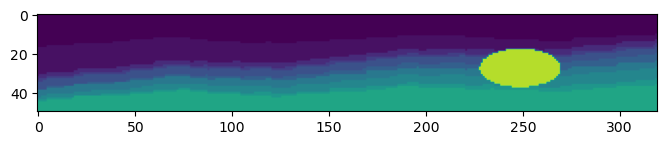

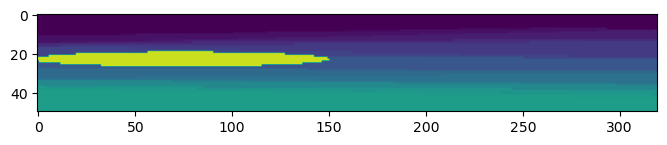

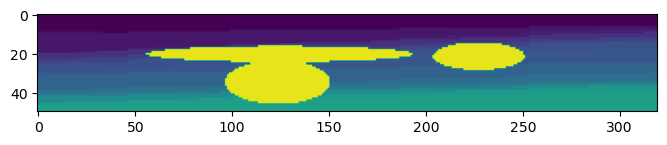

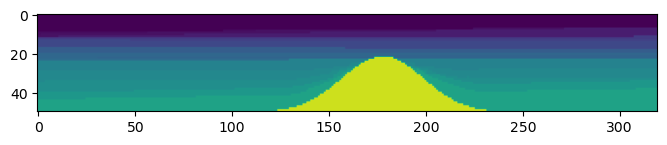

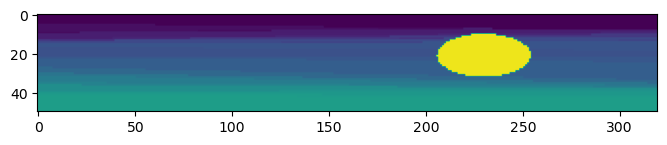

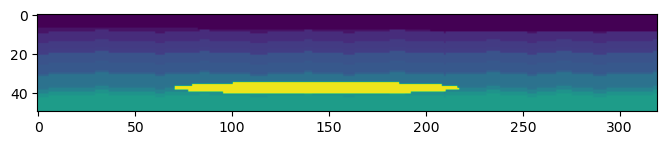

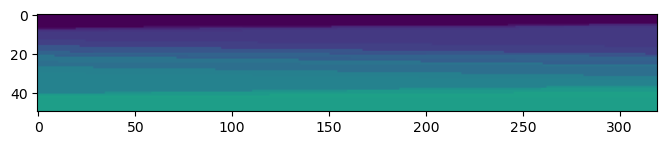

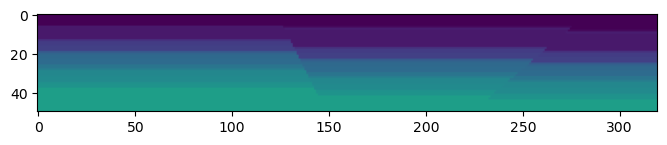

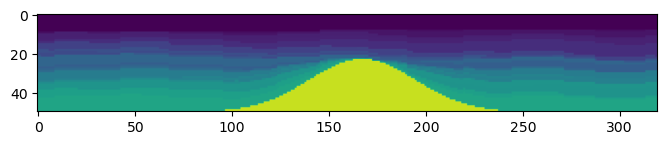

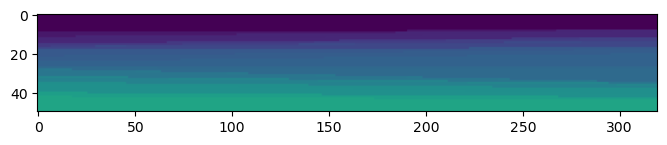

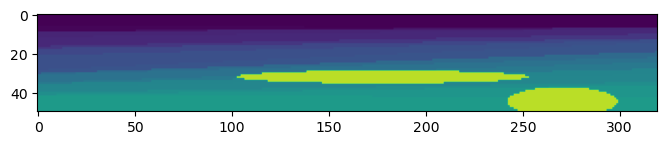

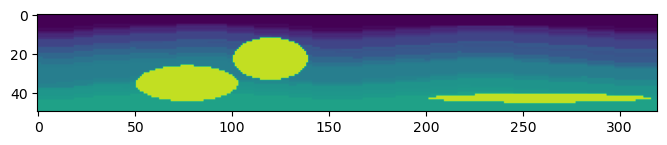

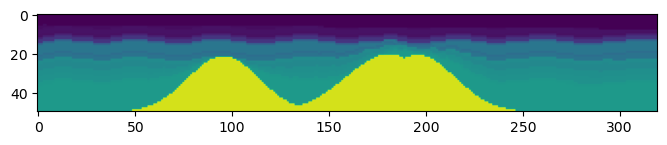

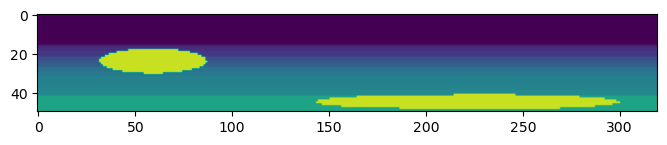

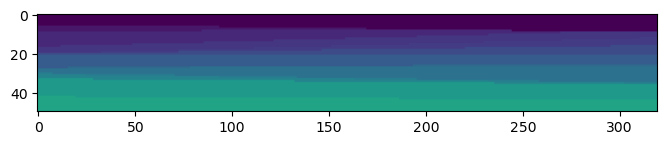

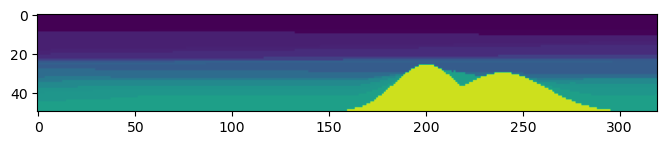

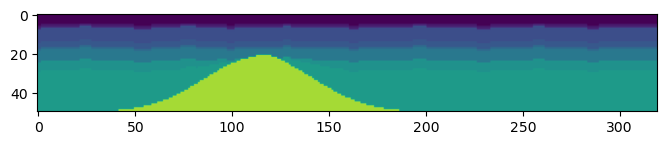

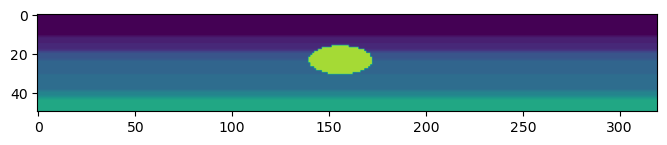

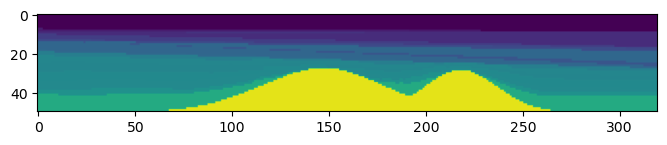

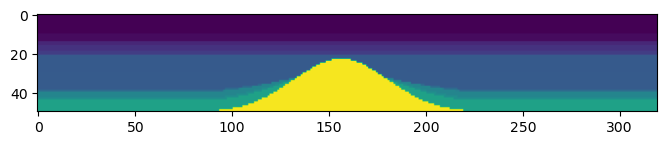

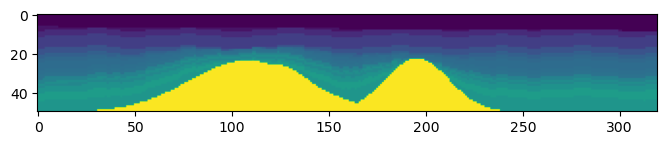

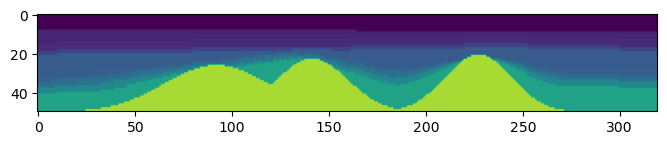

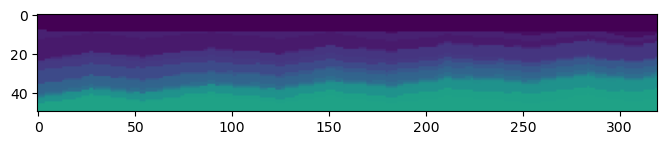

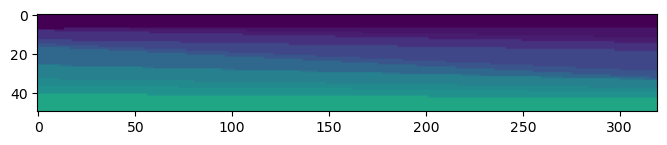

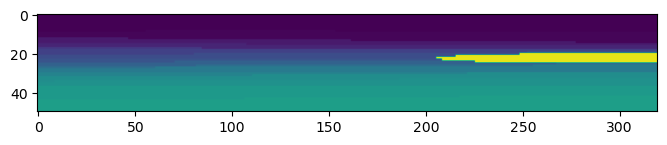

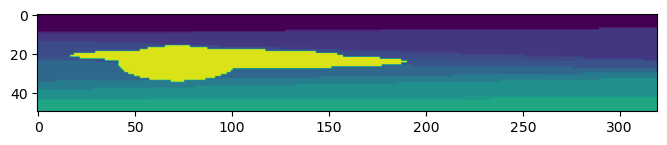

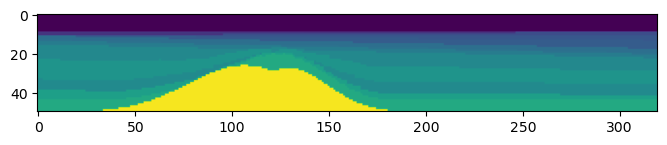

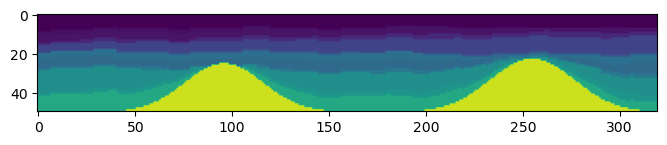

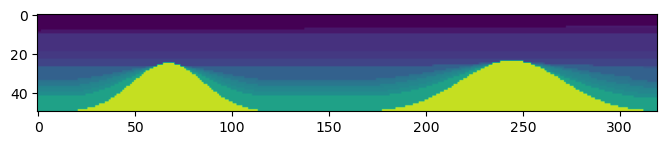

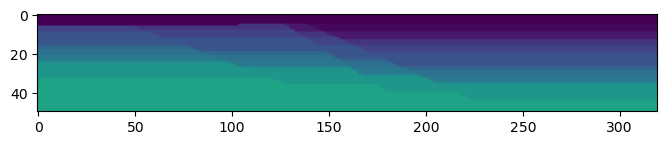

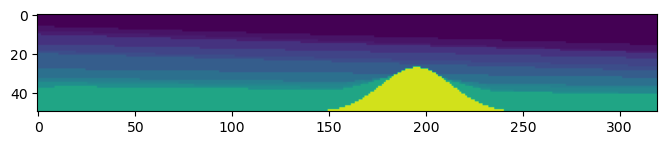

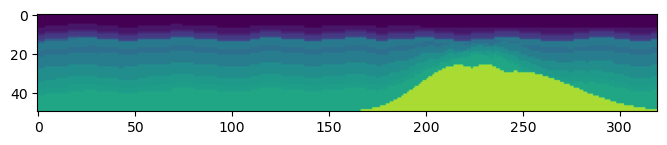

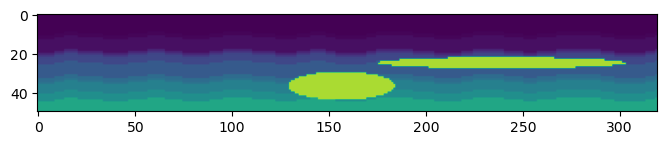

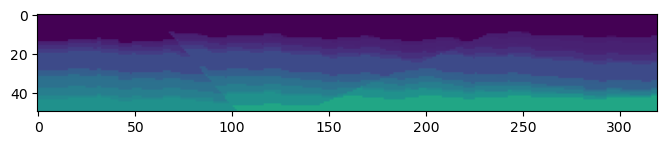

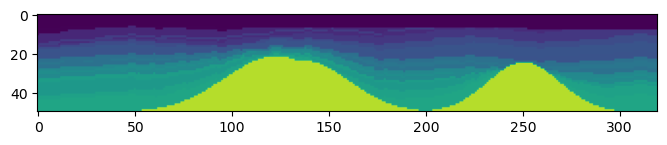

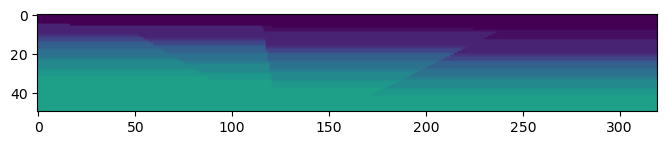

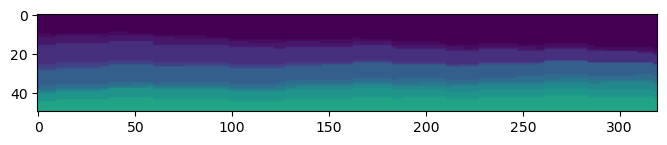

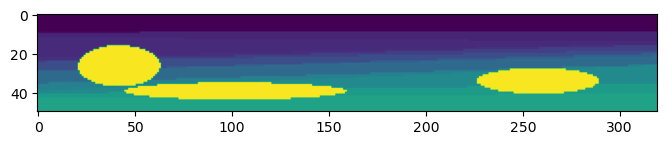

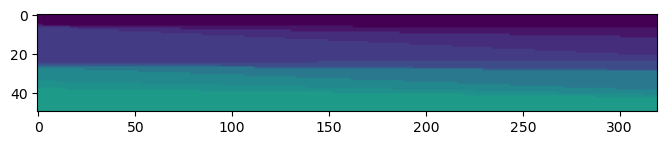

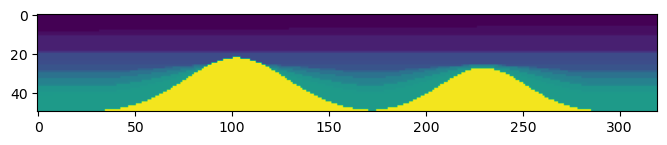

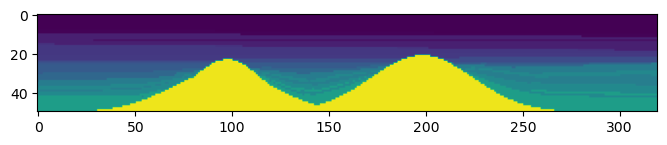

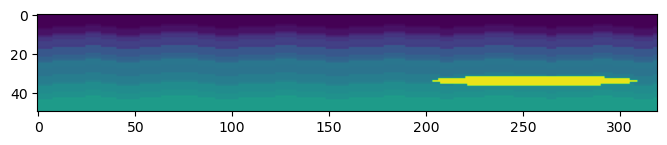

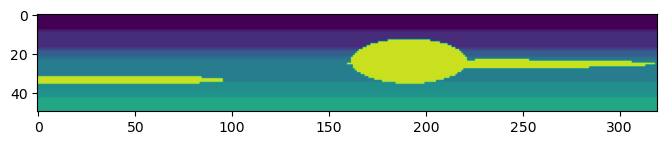

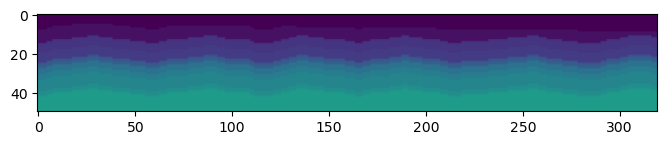

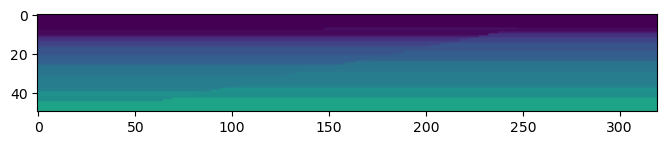

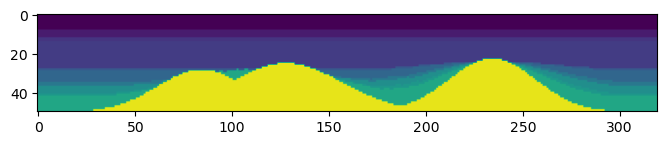

In [27]:
figsize=[8,3]

for i in range(1,51):
    plt.figure(figsize=figsize)
    vel = np.fromfile("./pred/nCNN/label_test%05d.bin"%(BATCH_SIZE * i),dtype=np.float32)
    vel.shape=(320,50)
    plt.imshow(vel.T,vmin=1.5,vmax=5.0)
plt.show()